In [2]:
# Hugging Face dataset bootstrapping
OWNER_NAME = 'competitions/'
DATASET_NAME = 'aiornot'

!pip install -Uqq datasets
!pip install -Uqq python-dotenv

from dotenv import load_dotenv
import os
from pathlib import Path
from datasets import load_dataset


load_dotenv('/notebooks/.env')
access_token = os.environ.get('HF_TOKEN')
DOWNLOADS = Path('downloads')
path = DOWNLOADS/DATASET_NAME

print('about to download', OWNER_NAME+DATASET_NAME, 'to', DOWNLOADS)
ds = load_dataset(OWNER_NAME+DATASET_NAME, use_auth_token=access_token)
print('done')

about to download competitions/aiornot to downloads


Using custom data configuration competitions--aiornot-c64672d1851055ac
Found cached dataset parquet (/root/.cache/huggingface/datasets/competitions___parquet/competitions--aiornot-c64672d1851055ac/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/2 [00:00<?, ?it/s]

done


## Data preprocessing
Moving csv format to images in folders

In [3]:
from datasets import Image as ImageFeature
ds = ds.cast_column('image', ImageFeature())
ds

DatasetDict({
    train: Dataset({
        features: ['id', 'image', 'label'],
        num_rows: 18618
    })
    test: Dataset({
        features: ['id', 'image', 'label'],
        num_rows: 43442
    })
})

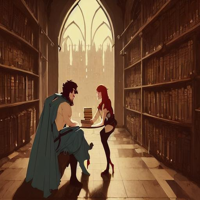

In [4]:
sample_img = ds['train'][1337]['image']
sample_img.thumbnail((200,200))
sample_img

In [5]:
ds['train'].info

DatasetInfo(description='', citation='', homepage='', license='', features={'id': Value(dtype='string', id=None), 'image': Image(decode=True, id=None), 'label': Value(dtype='int64', id=None)}, post_processed=None, supervised_keys=None, task_templates=None, builder_name='parquet', config_name='competitions--aiornot', version=0.0.0, splits={'train': SplitInfo(name='train', num_bytes=710871444, num_examples=18618, shard_lengths=None, dataset_name='parquet'), 'test': SplitInfo(name='test', num_bytes=1665842505, num_examples=43442, shard_lengths=[20861, 21721, 860], dataset_name='parquet')}, download_checksums={'https://huggingface.co/datasets/competitions/aiornot/resolve/799af3344961cbc8bd71c8151db06700e222d9d2/data/train-00000-of-00002-9767f7576a73674b.parquet': {'num_bytes': 353957464, 'checksum': '44bfa05ca357a020877248ea205a3d82cdd0494b6671b4c607dad34a6dd9df58'}, 'https://huggingface.co/datasets/competitions/aiornot/resolve/799af3344961cbc8bd71c8151db06700e222d9d2/data/train-00001-of-0

Let's save the dataset in folders 

In [6]:
path

PosixPath('downloads/aiornot')

In [7]:
path.mkdir(exist_ok=True)

In [8]:
(path/'train'/'0').mkdir(exist_ok=True)
(path/'train'/'1').mkdir(exist_ok=True)
(path/'test'/'0').mkdir(exist_ok=True)
(path/'test'/'1').mkdir(exist_ok=True)

In [140]:
from PIL import Image
from tqdm.auto import tqdm

# save train images to folder
for i, fname in tqdm(enumerate(ds['train']['id']), total=ds['train'].num_rows):
    img = ds['train'][i]['image']
    label = str(ds['train'][i]['label'])
    fpath = path/'train'/label/fname
    #print(fpath)
    if not fpath.is_file():
        img.save(fpath)

  0%|          | 0/18618 [00:00<?, ?it/s]

In [156]:
# save test images to folder
for i, fname in tqdm(enumerate(ds['test']['id']), total=ds['test'].num_rows):
    img = ds['test'][i]['image']
    label = str(ds['test'][i]['label'])
    fpath = path/'test'/fname
    #print(fpath)
    if not fpath.is_file():
        img.save(fpath)

  0%|          | 0/43442 [00:00<?, ?it/s]

### fastai baseline vision learner

In [9]:
# gpu memory management
import gc, torch
!pip install -Uqq pynvml

def free_gpu():
    gc.collect()
    torch.cuda.empty_cache()
    
def report_gpu():
    print(torch.cuda.list_gpu_processes())
    free_gpu()

In [10]:
report_gpu()

GPU:0
no processes are running


In [11]:
from fastai.vision.all import *

files = get_image_files(path/'train')
len(files)

18618

In [12]:
dls = ImageDataLoaders.from_folder(path/'train', valid_pct=0.25,
                                  item_tfms=Resize(64))
print(len(dls.train), len(dls.valid))

218 73


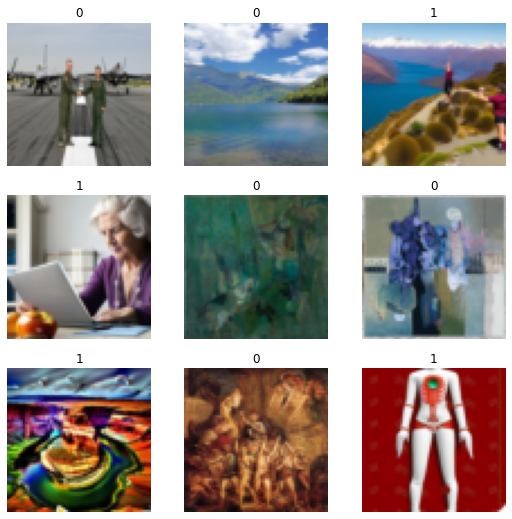

In [13]:
dls.show_batch()

In [16]:
learn = vision_learner(dls, resnet152, metrics=error_rate).to_fp16()

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [17]:
learn.fine_tune(5, 1e-3)

epoch,train_loss,valid_loss,error_rate,time
0,0.619547,0.521652,0.196820,00:47


epoch,train_loss,valid_loss,error_rate,time
0,0.333541,0.349017,0.131285,00:31
1,0.194747,0.389610,0.110443,00:32
2,0.089193,0.379865,0.098410,00:32
3,0.022583,0.418711,0.094327,00:32
4,0.013307,0.486731,0.092823,00:32


In [36]:
report_gpu()

GPU:0
process      27207 uses    10485.000 MB GPU memory


In [31]:
big_dls = ImageDataLoaders.from_folder(path/'train', valid_pct=0.2, item_tfms=Resize(256))
print(len(big_dls.train), len(big_dls.valid))

232 59


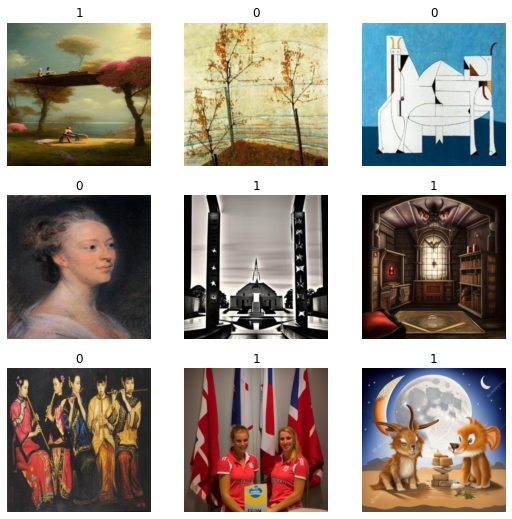

In [34]:
big_dls.show_batch()

In [32]:
learn.dls = big_dls

In [33]:
learn.fine_tune(3, 1e-3)

epoch,train_loss,valid_loss,error_rate,time
0,0.399002,0.335686,0.097771,01:28


epoch,train_loss,valid_loss,error_rate,time
0,0.261303,0.270495,0.085684,01:49
1,0.202619,0.224159,0.076283,01:49
2,0.191480,0.216023,0.074134,01:49


In [35]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,error_rate,time
0,0.153903,0.128385,0.052646,01:48


In [37]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,error_rate,time
0,0.132951,0.115243,0.048885,01:49


In [39]:
learn.fit_sgdr(3, 1)

epoch,train_loss,valid_loss,error_rate,time
0,0.080409,0.098404,0.039753,01:48
1,0.076805,0.094563,0.038141,01:49
2,0.056996,0.091126,0.037067,01:49
3,0.056222,0.089773,0.034381,01:49
4,0.046136,0.092416,0.035455,01:49
5,0.033000,0.089988,0.034112,01:49
6,0.025095,0.087548,0.033575,01:49


## Evaluate on test files

In [40]:
test_files = get_image_files(path/'test')
len(test_files)

43442

In [41]:
test_dl = learn.dls.test_dl(test_files)
preds, _ = learn.tta(dl=test_dl)

In [42]:
preds[:, 1]

TensorBase([9.9996e-01, 2.2387e-03, 9.4243e-01,  ..., 1.6475e-04,
            9.9785e-01, 9.9992e-01])

## Prepare submission file

In [43]:
submission = pd.read_csv(path/'sample_submission.csv')
submission.shape

(43442, 2)

In [44]:
submission.label = preds[:, 1]
submission

,id,label
0,0.jpg,0.999964
1,1.jpg,0.002239
2,10.jpg,0.942427
3,100.jpg,0.000051
4,1000.jpg,0.999764
...,...,...
43437,9995.jpg,0.678080
43438,9996.jpg,0.999984
43439,9997.jpg,0.000165
43440,9998.jpg,0.997851


In [45]:
submission.label.mean()

0.55521065

## Submit CSV to Hugging Face

In [46]:
# write submission csv
technique = '-resnet152 complex regime tta undecoded-'
sub_filename = Path('subs')/(DATASET_NAME+'-'+technique+'-sub.csv')
submission.to_csv(sub_filename, index=False)
print('done')

done
